# Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ
# Домашнее задание: классификация Симпсонов

В данном задании вам предстоит осуществить путешевствие в мир Спрингфилда, где вы сможете познакомиться со всеми любимыми персонажами Симпсонов.

Основным заданием будет обучить классификатор на основе сверточных сетей, чтобы научиться отличать всех жителей Спрингфилда.

**Это финальная версия моих манипуляций с данными и сетью. Все предыдущие давали очень низкий скор**

Team Name на $Kaggle$ - Светлана_Астафьева_120279458 (на 22.04.2021 460 место, скор 0.98512)

Если кратко о работе:
- Работа выполнена в Colab. Данные скачаны архивом со страницы сореновнования Kaggle.
- Сохранена структура baseline_ноутбука, исправлены ошибки, созданы дополнительные функции. Например, чтобы отрисовывать картинки не только из валидационного датасета, но и из обучающего.
- Добавилен расчет статистики по датасету. Расчеты не пригодились, но выглядит красиво))
- Использована аугментация, поэтому трансформеры в классе Симпсонов переписаны.
- Загружена предобученная сеть mobilenet_v2 и обучена целиком (я пробовала размораживать слои, но скор получался низкий). Эту сеть я выбрала, потому что у нее очень скромные размеры, в сравнении с другими сетями. Другие сети не пробовала. Дорабатывать simple_nn из бейзлайна я не стала, т.к. у меня недостаточно опыта, чтобы решить, какие улучшения могут привести к повышению качества, сеть учится не 5 минут, а времени попробовать все, что хочется, не хватает.
- Фиксирован random_seed разными способами. Но я не уверена, что загрузка батчей детерменирована. В любом случае, не думаю, что если заново обучить сеть, получится существенное различие в качестве.
- Словарь модели сохранен на гугл-диск (не в корень), чтобы к нему был доступ в любой момент.

# Импортируем библиотеки

In [1]:
import os
import pickle
from PIL import Image
from tqdm import tqdm, tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import random
from pathlib import Path

import torchvision
from torchvision import datasets, models, transforms

from matplotlib import colors, pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)

import time
%matplotlib inline


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


Ниже выведен список версий всех библиотек, использованных при создании этого ноутбука. Также, этот список был выгружен в файл requirements.txt, который приложен к работе.

In [ ]:
!pip freeze > requirements.txt 

In [ ]:
!pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
astor==0.8.1
astropy==4.2.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.1
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.22
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
dlib==19.18.0
dm-tree==0.1.6
docopt==0.6.2


In [2]:
torch.cuda.is_available()

True

Если torch.cuda.is_available() = False, проверьте Среда выполнения -> Cменить среду выполнения -> Если аппаратный ускоритель None, выберете GPU и запустите заново ячейки выше

Для обеспечения воспроизводимости напишем 2 функции. При обучении будем менять seed на каждой эпохе.

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    # torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
set_seed(2147483647)

В [документации Pytorch](https://pytorch.org/docs/stable/notes/randomness.html) есть совет, как сделать процесс загрузки батчей детерменированным. Но я не уверена, что это хорошая идея, потому что я применяю аугментацию, и необходимо обеспечить рандомность преобразований. Чтобы использовать этот способ, нужно внимательно с этим разобраться.

# Загрузим данные

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
# Измените путь на свой (где лежит архив с данными с Каггл), 
# чтобы в дальнейшем все ячейки с сохранением и чтением файлов отрабатывали корректно
DATA_DIR = '/content/gdrive/MyDrive/DLS_MFTI/DLS_adv/W6_image_classif/data_simpsons/'
DATA_DIR_PATH = Path(DATA_DIR)

Я скачала dataset с Kaggle и поместила архив на свой диск. Выше я подключилась к своему диску. Далее, я распакую архив и укажу пути к выборкам с помощью path.

In [7]:
#Разархивируем данные (укажите свой путь к архиву с данными с Каггл)
!unzip -q /content/gdrive/MyDrive/DLS_MFTI/DLS_adv/W6_image_classif/data_simpsons/journey-springfield.zip -d data_simps

In [8]:
TRAIN_DIR = Path('/content/data_simps/train/simpsons_dataset')
TEST_DIR = Path('/content/data_simps/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

# Выполним предобработку данных

In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок, 
    кодирует метки классов, 
    выполняет аугментацию обучающей выборки, 
    масштабирует картинки и превращает в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        image_transforms = {
                      # Train с аугментацией
                      'train':
                      transforms.Compose([
                          transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                          transforms.RandomPerspective(distortion_scale=0.1),
                          transforms.RandomRotation(degrees=15),
                          transforms.ColorJitter(),
                          transforms.RandomHorizontalFlip(),
                          transforms.CenterCrop(size=RESCALE_SIZE),  
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406],
                                              [0.229, 0.224, 0.225])  # Imagenet standards
                      ]),
                      # Val без аугментации
                      'val':
                      transforms.Compose([
                          transforms.Resize(size=256),
                          transforms.CenterCrop(size=RESCALE_SIZE),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                      ]),
                      # Test без аугментации
                      'test':
                      transforms.Compose([
                          transforms.Resize(size=256),
                          transforms.CenterCrop(size=RESCALE_SIZE),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                      ]),
        }
                
        
        x = self.load_sample(self.files[index])
        
        # В зависимости от состояния возвращаем или нет класс и разные трансформации x
        if self.mode == 'train':
            x = image_transforms['train'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        elif self.mode == 'val':
            x = image_transforms['val'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        else:
            x = image_transforms['test'](x)
            return x
        
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

# Выведем статистику по датасету

Сделаем 2 таблицы (с количеством примеров каждого класса и с размером изображений)

In [ ]:
traindir = '/content/data_simps/train/simpsons_dataset/'
categories = []
img_categories = []
n_train = []
hs = []
ws = []

# Итерируемся по каждой категории

for d in os.listdir(traindir):
    categories.append(d)

    
    train_imgs = os.listdir(traindir + d)
    n_train.append(len(train_imgs))
    

    
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe с количеством изображений по категориям
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                        }).sort_values('category')

# Dataframe с размерами изображений по категориям
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

In [ ]:
cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head(42)

,category,n_train
17,homer_simpson,2246
16,ned_flanders,1454
5,moe_szyslak,1452
35,lisa_simpson,1354
39,bart_simpson,1342
31,marge_simpson,1291
28,krusty_the_clown,1206
33,principal_skinner,1194
37,charles_montgomery_burns,1193
0,milhouse_van_houten,1079


Есть 3 класса с количеством примеров меньше 10.

Визуализируем распределение количество примеров по классам

Text(0.5, 1.0, 'Training Images by Category')

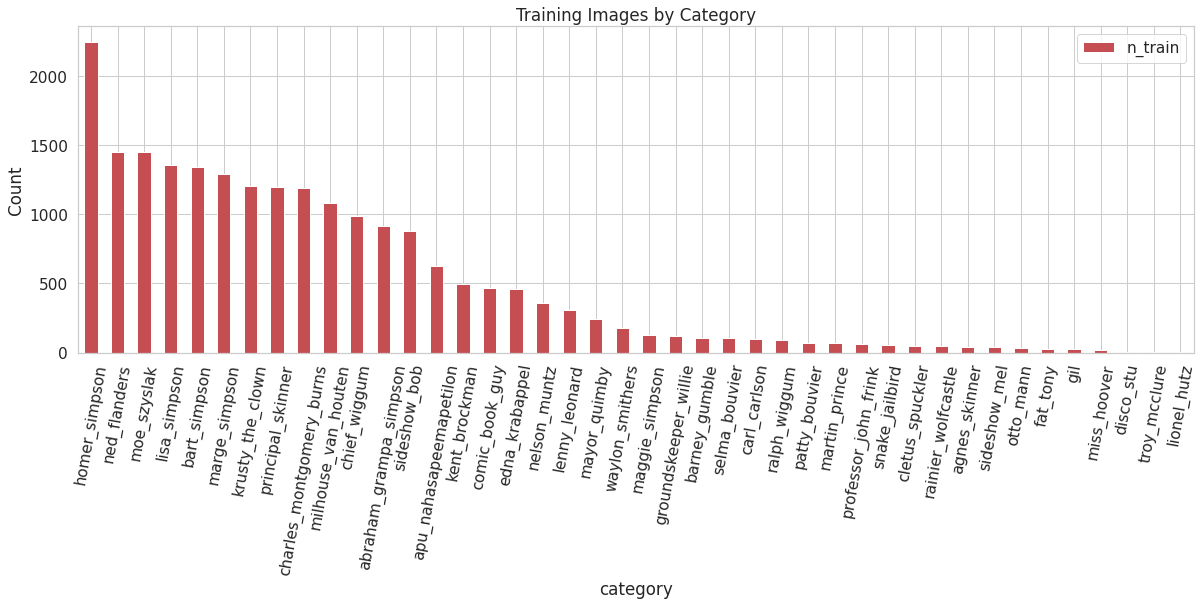

In [ ]:
cat_df.set_index('category').plot.bar(color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

Посмотрим на минимальные размеры картинок

In [ ]:
'image_height_min', image_df.height.min(), 'image_width_min', image_df.width.min()

('image_height_min', 256, 'image_width_min', 256)

# Создадим датасеты (для обучения, валидации и предсказания)

In [10]:
torch.cuda.is_available()

True

In [11]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels, random_state=1)

In [13]:
train_files_labels = [path.parent.name for path in train_files]
val_files_labels = [path.parent.name for path in val_files]

In [ ]:
print(f'Обучающая выборка: размер - {len(train_files_labels)}, классов - {len(set(train_files_labels))}.', 
      f'Валидационная выборка: размер - {len(val_files_labels)}, классов - {len(set(val_files_labels))}.')

Обучающая выборка: размер - 16746, классов - 42. Валидационная выборка: размер - 4187, классов - 42.


In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

# Функции для визуализации изображений

### Функции для отрисовки случайных изображений из обучающей и валидационной выборки

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


def imshow_train_val(nrows, ncols, mode):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16, 8), \
                            sharey=True, sharex=True)
    for fig_x in ax.flatten():
        
        if mode == 'train':
          random_characters = int(np.random.uniform(0, len(train_dataset)))
          im_mode, label = train_dataset[random_characters]
          img_label = " ".join(map(lambda x: x.capitalize(),\
                     train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
        
        elif mode == 'val':
          random_characters = int(np.random.uniform(0, len(val_dataset)))
          im_mode, label = val_dataset[random_characters]
          img_label = " ".join(map(lambda x: x.capitalize(),\
                     val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

        imshow(im_mode.data.cpu(), title=img_label,plt_ax=fig_x)

# Визуализация валидационной и обучающей выборки

Посмотрим на изображения, сгенерированные из обучающей выборки и убедимся, что выбранные трансформации для аугментации не критично искажают картинки

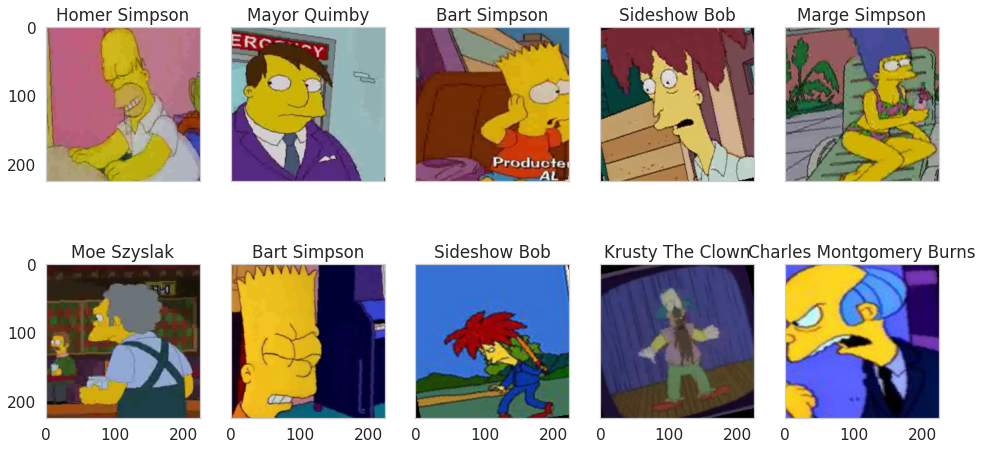

In [ ]:
imshow_train_val(2, 5, 'train')

Посмотрим на валидационную выборку

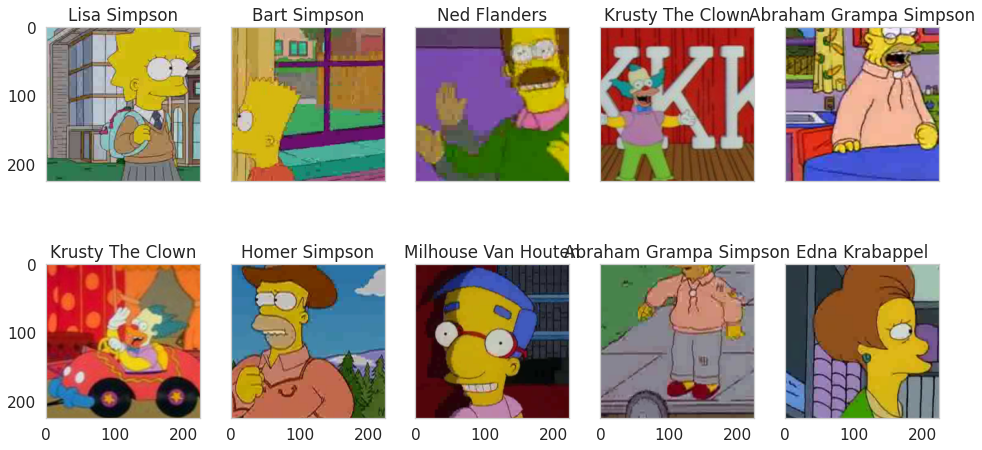

In [ ]:
imshow_train_val(2, 5, 'val')

# Функции для обучения сети

Функция для обучения в эпохе

In [14]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

Функция для валидации в эпохе

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

Функция обучения модели

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size, criterion, optimizer, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0


    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):
            set_seed(2147483647 + epoch)
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            scheduler.step()
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
                       
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc)) 

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)

    return model, history

Функция для получения предсказаний

In [15]:
def predict(model, test_loader):
    torch.manual_seed(1)
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Функция для отрисовки лоссов

In [ ]:
def visual_loss(history):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

# Загрузка предобученной нейронной сети

Загрузим mobilenet_v2

In [ ]:
model_mbnet = models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Посмотрим, что внутри

In [ ]:
model_mbnet

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

# Обучение модели

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 1280

# n_classes - кол-во классов для классификации
n_classes = len(np.unique(train_val_labels))

# Заменяем Fully-Connected слой на наш линейный классификатор
model_mbnet.classifier = nn.Sequential(
                      nn.Dropout(p=0.2, inplace=False),
                      nn.Linear(num_features, n_classes)
)


# Переводим модель на GPU
model_mbnet = model_mbnet.to(DEVICE)

# В качестве cost function используем кросс-энтропию
criterion_mbnet = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск. Обучаем только последний слой.
optimizer_mbnet = optim.Adam(model_mbnet.parameters(), lr=1e-4)

# Умножаем learning_rate на 0.1 каждые 4 эпохи
scheduler_mbnet = lr_scheduler.StepLR(optimizer_mbnet, step_size=4, gamma=0.1)

In [ ]:
%%time
model_mbnet, history = train(train_dataset, val_dataset, model_mbnet, epochs = 9, batch_size=32, 
                             criterion=criterion_mbnet, 
                             optimizer=optimizer_mbnet, 
                             scheduler=scheduler_mbnet
                             )

epoch:   0%|          | 0/9 [00:00<?, ?it/s]

loss 0.8768017581432336


epoch:  11%|█         | 1/9 [03:37<28:58, 217.32s/it]


Epoch 001 train_loss: 0.8768     val_loss 0.3687 train_acc 0.8040 val_acc 0.9143
loss 0.2931564810651221


epoch:  22%|██▏       | 2/9 [07:12<25:16, 216.66s/it]


Epoch 002 train_loss: 0.2932     val_loss 0.3720 train_acc 0.9237 val_acc 0.9057
loss 0.15650119499819393


epoch:  33%|███▎      | 3/9 [10:46<21:36, 216.01s/it]


Epoch 003 train_loss: 0.1565     val_loss 0.2405 train_acc 0.9574 val_acc 0.9436
loss 0.12200851082433872


epoch:  44%|████▍     | 4/9 [14:23<18:00, 216.02s/it]


Epoch 004 train_loss: 0.1220     val_loss 0.2354 train_acc 0.9667 val_acc 0.9415
loss 0.05459153820350335


epoch:  56%|█████▌    | 5/9 [17:58<14:23, 215.95s/it]


Epoch 005 train_loss: 0.0546     val_loss 0.1786 train_acc 0.9873 val_acc 0.9613
loss 0.03986836039842378


epoch:  67%|██████▋   | 6/9 [21:34<10:47, 215.99s/it]


Epoch 006 train_loss: 0.0399     val_loss 0.1772 train_acc 0.9909 val_acc 0.9611
loss 0.03341863195527651


epoch:  78%|███████▊  | 7/9 [25:11<07:12, 216.25s/it]


Epoch 007 train_loss: 0.0334     val_loss 0.1834 train_acc 0.9931 val_acc 0.9608
loss 0.03036443712264317


epoch:  89%|████████▉ | 8/9 [28:47<03:36, 216.02s/it]


Epoch 008 train_loss: 0.0304     val_loss 0.1763 train_acc 0.9934 val_acc 0.9632
loss 0.024380649872116186


epoch: 100%|██████████| 9/9 [32:23<00:00, 215.89s/it]


Epoch 009 train_loss: 0.0244     val_loss 0.1751 train_acc 0.9948 val_acc 0.9642
Training complete in 32m 23s
Best val Acc: 0.964175
CPU times: user 27min 54s, sys: 4min 33s, total: 32min 28s
Wall time: 32min 23s


In [ ]:
# Нужно не забыть записать лучшую модель (Путь для записи указывайте свой в DATA_DIR_PATH. Мой путь ведет на мой google-диск)
torch.save(model_mbnet.state_dict(), Path(DATA_DIR_PATH, 'model_mbnet_01.pth'))

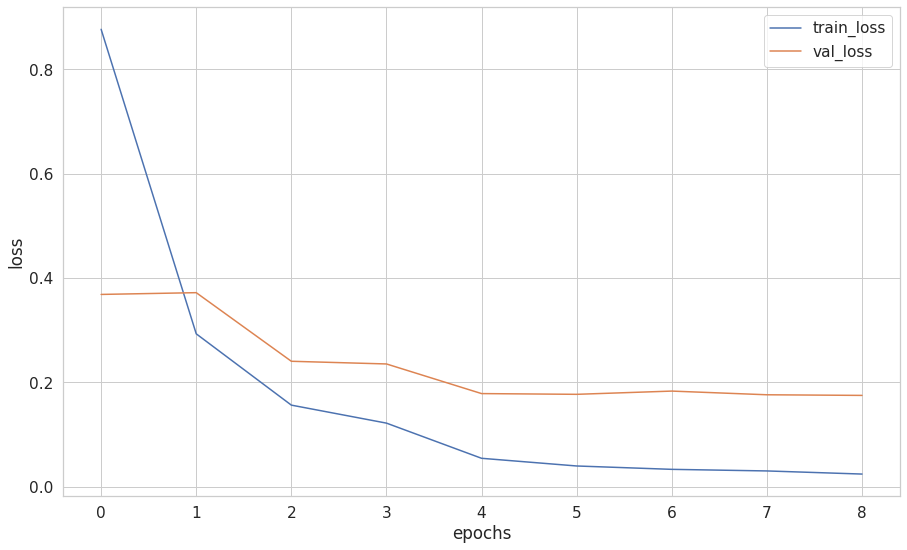

In [ ]:
visual_loss(history)

# Загрузка обученной модели

Важно выполнить заново загрузку предобученной модели и ячейку с переопределением последнего слоя (классификатора)

In [ ]:
# Загрузка модели (чтобы не обучать заново каждый раз при запуске)
model_mbnet.load_state_dict(torch.load(Path(DATA_DIR_PATH, 'model_mbnet_01.pth')))

<All keys matched successfully>

# Визуализация точности предсказаний валидационного датасета

Функция предсказания для одной картинки

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
      inputs = inputs.to(device)
      model.eval()
      logit = model(inputs).cpu()
      probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Функция для расчета F1 для предсказаний случайной выборки из валидационного датасета

In [ ]:
def f1_val_score(num_samples, model):
  idxs = list(map(int, np.random.uniform(0, len(val_dataset), num_samples)))
  imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

  probs_ims = predict(model, imgs)

  y_pred = np.argmax(probs_ims,-1)
  actual_labels = [val_dataset[id][1] for id in idxs]

  return f1_score(actual_labels, y_pred, average='micro')



Посчитаем F1 для случайных 300 изображений из валидационной выборки

In [ ]:
f1_val_score(300, model_mbnet)

0.9633333333333334

Функция для визуализации уверенности предсказаний модели

In [ ]:
# Дальше понадобится сохранненый label_encoder (который был записан при создании датасетов через класс Симпсонов)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
def visual_preds(nrows, ncols, model, label_encoder):

  fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16, 8), \
                            sharey=True, sharex=True)
  for fig_x in ax.flatten():
      random_characters = int(np.random.uniform(0, len(val_dataset)))
      im_val, label = val_dataset[random_characters]
      img_label = " ".join(map(lambda x: x.capitalize(),\
                    val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
        
        

      imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)
        
      actual_text = "Actual : {}".format(img_label)
                
      fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
      font0 = FontProperties()
      font = font0.copy()
      font.set_family("serif")
      prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
      predicted_proba = np.max(prob_pred)*100
      y_pred = np.argmax(prob_pred)
        
      predicted_label = label_encoder.classes_[y_pred]
      predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
      predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
                
      fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                        verticalalignment='top',fontsize=10, color='black',fontweight='bold')

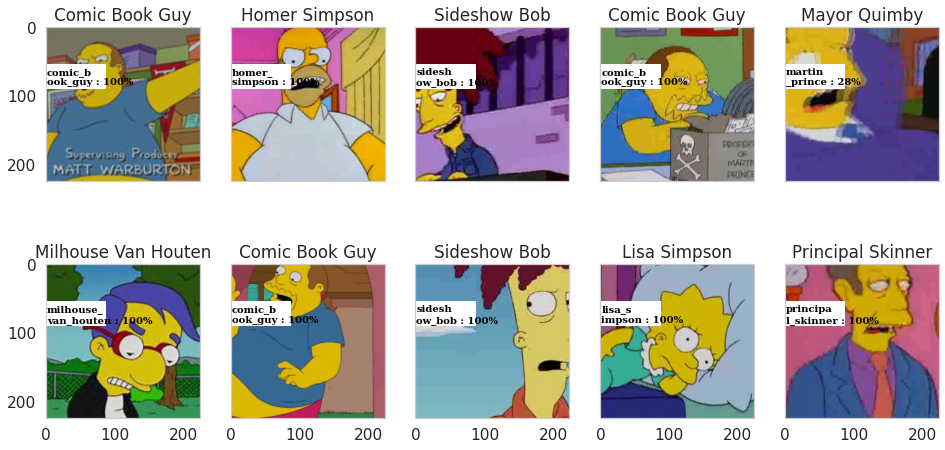

In [ ]:
visual_preds(2, 5, model_mbnet, label_encoder)

В общем, довольно хорошо. Из 10 картинок не распознана всего 1, но ее качество оставляет желать лучшего :-)

# Submit на Kaggle

In [ ]:
# Дальше понадобится сохранненый label_encoder (который был записан при создании датасетов через класс Симпсонов)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

Функция для предсказания и записи предсказаний в Dataframe

In [ ]:
def submit_df(model, label_encoder, batch_size):
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
  
  probs = predict(model, test_loader)
  preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
  test_filenames = [path.name for path in test_dataset.files]
  
  my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

  return my_submit

In [ ]:
# Запись предсказаний в файл (Путь для записи указывайте свой в DATA_DIR_PATH. Мой путь ведет на мой google-диск)

my_submit_mbnet_01 = submit_df(model_mbnet, label_encoder, 64)
my_submit_mbnet_01.to_csv(Path(DATA_DIR_PATH, 'mbnet_01_test_saved_model.csv'), index=False)

$F1-score$ на $Kaggle$ составила $0.98512$. Выше, чем на валидационном датасете. Можно говорить о том, что переобучения не произошло. 

На мой взгляд, это хороший результат для обучения за 32 минуты на датасете, в котором не все изображения можно однозначно идентифицировать, а некоторые классы содержат менее 20 примеров.

Я протестировала загруженную модель (не обучая заново), качество точно такое же. Значит, все работает корректно.

# Дообучение модели на валидацинном датасете

Чтобы код ниже сработал, требуется запустить некоторые разделы выше:
- Импортируем библиотеки
- Загрузим данные
- Выполним предобработку данных
- Создадим датасеты
- Функции для обучения сети

Также, требуется указать правильный путь для загрузки словаря ранее обученной модели (если обучение не проводилось заново).

Инициализируем валидационный датасет, как обучающий (для применения аугментации). Обратите внимание, что разбивка обучающей выборки на train и val произведена выше. Я не стала копировать сюда.

In [16]:
val_dataset_for_train = SimpsonsDataset(val_files, mode='train')
test_dataset = SimpsonsDataset(test_files, mode='test')

Загрузим модель

In [17]:
model_mbnet_val = models.mobilenet_v2()

Заморозим первые слои, поменяем классификатор, зададим loss_function, optimizer, scheduler

In [ ]:
layers_to_unfreeze = 3

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mbnet_val.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 1280

# n_classes - кол-во классов для классификации
n_classes = len(np.unique(train_val_labels))

# Заменяем Fully-Connected слой на наш линейный классификатор
model_mbnet_val.classifier = nn.Sequential(
                      nn.Dropout(p=0.2, inplace=False),
                      nn.Linear(num_features, n_classes)
)


# Переводим модель на GPU
model_mbnet_val = model_mbnet_val.to(DEVICE)


# В качестве cost function используем кросс-энтропию
criterion_val = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров параметров, поэтому два таких списка можно сложить
optimizer_mbnet_val = optim.Adam(list(model_mbnet_val.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mbnet_val.classifier.parameters()), lr=1e-4)

# Умножаем learning_rate на 0.1 каждые 3 эпохи 
scheduler_mbnet_val = lr_scheduler.StepLR(optimizer_mbnet_val, step_size=3, gamma=0.1)

Загрузим словарь модели, обученной на обучающей выборке

In [ ]:
model_mbnet_val.load_state_dict(torch.load(Path(DATA_DIR_PATH, 'model_mbnet_01.pth')))

<All keys matched successfully>

Напишем функцию для обучения на валидационной выборке

In [18]:
def train_onval(val_dataset, model, epochs, batch_size, criterion, optimizer, scheduler):
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0


    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    train_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):
            set_seed(2147483647 + epoch)
            
            train_loss, train_acc = fit_epoch(model, val_loader, criterion, optimizer)
            print("loss", train_loss)

            scheduler.step()
            
            #history.append((train_loss, train_acc))

            if train_acc > best_acc:
                best_acc = train_acc
                best_model_wts = model.state_dict()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc))
            
                       
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best train Acc: {:4f}'.format(best_acc)) 

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)

    return model

Обучим модель, сохраним словарь в новый документ

In [ ]:
torch.cuda.empty_cache()
torch.cuda.is_available()

True

В прошлый раз было достаточно 6 эпох для обучения

In [ ]:
%%time
model_mbnet_val = train_onval(val_dataset_for_train, model_mbnet_val, epochs = 6, batch_size=256, 
                             criterion=criterion_val, 
                             optimizer=optimizer_mbnet_val, 
                             scheduler=scheduler_mbnet_val
                             )

epoch:  17%|█▋        | 1/6 [00:50<04:11, 50.29s/it]

loss 0.22529986712851158

Epoch 001 train_loss: 0.2253     train_acc 0.9589


epoch:  33%|███▎      | 2/6 [01:40<03:20, 50.17s/it]

loss 0.19926687389263426

Epoch 002 train_loss: 0.1993     train_acc 0.9582


epoch:  50%|█████     | 3/6 [02:30<02:30, 50.07s/it]

loss 0.18683572113869837

Epoch 003 train_loss: 0.1868     train_acc 0.9620


epoch:  67%|██████▋   | 4/6 [03:19<01:39, 49.98s/it]

loss 0.18444344550833827

Epoch 004 train_loss: 0.1844     train_acc 0.9630


epoch:  83%|████████▎ | 5/6 [04:09<00:50, 50.01s/it]

loss 0.18169124891030808

Epoch 005 train_loss: 0.1817     train_acc 0.9630


epoch: 100%|██████████| 6/6 [05:00<00:00, 50.01s/it]

loss 0.1865145544469684

Epoch 006 train_loss: 0.1865     train_acc 0.9606
Training complete in 5m 0s
Best train Acc: 0.962981
CPU times: user 4min 23s, sys: 37.4 s, total: 5min 1s
Wall time: 5min


In [ ]:
# (Путь для записи указывайте свой в DATA_DIR_PATH. Мой путь ведет на мой google-диск)
torch.save(model_mbnet_val.state_dict(), Path(DATA_DIR_PATH, 'model_mbnet_02.txt'))

In [ ]:
# Загрузка модели (чтобы не обучать заново каждый раз при запуске)
model_mbnet_val.load_state_dict(torch.load(Path(DATA_DIR_PATH, 'model_mbnet_02.txt')))

<All keys matched successfully>

Сделаем предсказания и отправим на $Kaggle$

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

# Дублирую функцию для записи предсказаний, если не все ячейки выше запущены
def submit_df(model, label_encoder, batch_size):
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
  
  probs = predict(model, test_loader)
  preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
  test_filenames = [path.name for path in test_dataset.files]
  
  my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

  return my_submit


my_submit_mbnet_val = submit_df(model_mbnet_val, label_encoder, 128)
my_submit_mbnet_val.to_csv(Path(DATA_DIR_PATH, 'mbnet_02.csv'), index=False)

$F1-score$ на $Kaggle$ составила $0.9798$. Стало хуже.

$P.S.$ Я собиралась дообучить всю сеть на валидационном датасете, но постоянно получала ошибку о переполнении памяти. Несколько раз перезапускала среду. Ждала несколько часов и снова заходила. Но результат не менялся (в первый раз установка batch_size=32 решила проблему). 